# Выбор модели для предсказания химшлаков

Решение прямой задачи: предсказания химического состава шлака с оценкой в терминах регрессии

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error

from catboost import CatBoostRegressor

## Загрузка и подготовка данных

In [4]:
df = pd.read_csv('clean_data.csv', index_col=0)
df.head()

,МАРКА,t вып-обр,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
589,Э76ХФ,18.0,20.016667,41.850000,2.431057,0.339285,0.075060,0.066049,0.068946,0.038742,...,0.23,2.3,25.6,3.2,54.8,0.8,6.1,0.09,2.4,23.2
818,Э90ХАФ,7.0,17.383333,41.033333,3.004480,0.523411,0.108273,0.200457,0.148846,0.095573,...,0.11,2.4,24.5,4.6,61.8,0.5,6.1,0.08,2.4,26.1
1029,Другие,9.0,18.950000,43.850000,2.643735,0.433960,0.121086,0.175658,0.089606,0.041396,...,0.18,2.4,20.4,4.7,54.8,0.6,11.6,0.16,2.1,26.1
1036,Другие,7.0,19.216667,46.716667,3.000000,0.548870,0.121086,0.199137,0.087354,0.041748,...,0.25,2.3,23.8,5.4,51.9,0.5,10.3,0.15,2.1,24.2
1345,Э76ХФ,26.0,19.883333,42.050000,3.775293,0.402655,0.168487,0.176548,0.153988,0.041933,...,0.19,2.2,22.4,5.2,54.5,0.3,14.0,0.14,2.1,26.6


In [5]:
df.shape

(4576, 67)

In [6]:
target = [col for col in df.columns if col.startswith('химшлак последний')]

In [51]:
X = df.drop(target, axis=1)
X.shape

(4576, 60)

In [53]:
X = pd.get_dummies(X) # one-hot encoding для марки стали
X_cols = X.columns

In [54]:
# Нормализация данных
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

## Одновременное предсказание целевых переменных

In [1]:
def test_model(model, X, y):
    error = -cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5).mean()
    return error

In [23]:
def test_many_models(models, df, X, target):
    for model in models:
        print(model)
        errors = []
        for t in target:
            print(t)
            y = df[t]
            error = test_model(model, X, y)
            errors.append(error)
            print(f'{error*100:.2f}%')
        print()
        print(f'Средняя ошибка модели: {np.mean(errors)*100:.2f}%\n')

### Линейные модели

In [21]:
models = [LinearRegression(), Lasso(), Ridge()] # Линейные модели в качестве бейзлайна

In [24]:
test_many_models(models, df, X, target)

LinearRegression()
химшлак последний Al2O3
11.35%
химшлак последний CaO
4.82%
химшлак последний FeO
35.56%
химшлак последний MgO
25.74%
химшлак последний MnO
29.45%
химшлак последний R
6.13%
химшлак последний SiO2
6.96%

Средняя ошибка модели: 17.14%

Lasso()
химшлак последний Al2O3
16.60%
химшлак последний CaO
5.24%
химшлак последний FeO
36.17%
химшлак последний MgO
31.02%
химшлак последний MnO
35.59%
химшлак последний R
8.21%
химшлак последний SiO2
8.26%

Средняя ошибка модели: 20.16%

Ridge()
химшлак последний Al2O3
11.34%
химшлак последний CaO
4.81%
химшлак последний FeO
35.56%
химшлак последний MgO
25.76%
химшлак последний MnO
29.47%
химшлак последний R
6.14%
химшлак последний SiO2
6.96%

Средняя ошибка модели: 17.15%



Линейные модели дают среднюю ошибку 17% в лучшем случае

### Деревья

In [25]:
models = [RandomForestRegressor()]

In [26]:
test_many_models(models, df, X, target)

RandomForestRegressor()
химшлак последний Al2O3
11.56%
химшлак последний CaO
4.92%
химшлак последний FeO
36.36%
химшлак последний MgO
26.47%
химшлак последний MnO
33.31%
химшлак последний R
6.18%
химшлак последний SiO2
7.07%

Средняя ошибка модели: 17.98%



Неоптимизированные деревья в среднем показали себя хуже

### Бустинги

In [27]:
models = [CatBoostRegressor(loss_function='MAPE', n_estimators=1000, silent=True)]
test_many_models(models, df, X, target)

химшлак последний Al2O3
11.04%
химшлак последний CaO
4.95%
химшлак последний FeO
34.37%
химшлак последний MgO
24.90%
химшлак последний MnO
27.39%
химшлак последний R
5.96%
химшлак последний SiO2
6.79%

Средняя ошибка модели: 16.48%



## Выбор и создание новых признаков

### Создание полиномиальных признаков

In [29]:
poly = PolynomialFeatures(2)
poly_X = poly.fit_transform(X)

In [30]:
poly_X.shape

(4576, 2016)

In [31]:
models = [LinearRegression(), Ridge(), Lasso()]
test_many_models(models, df, poly_X, target)

LinearRegression()
химшлак последний Al2O3
16461717212.96%
химшлак последний CaO
6000872479.03%
химшлак последний FeO
8923416696.87%
химшлак последний MgO
27967452752.08%
химшлак последний MnO
45204367012.79%
химшлак последний R
17993140991.87%
химшлак последний SiO2
22350536633.81%

Средняя ошибка модели: 20700214825.63%

Ridge()
химшлак последний Al2O3
21.05%
химшлак последний CaO
8.52%
химшлак последний FeO
61.35%
химшлак последний MgO
44.71%
химшлак последний MnO
60.66%
химшлак последний R
10.61%
химшлак последний SiO2
12.52%

Средняя ошибка модели: 31.35%

Lasso()
химшлак последний Al2O3
16.61%
химшлак последний CaO
5.24%
химшлак последний FeO
36.17%
химшлак последний MgO
31.03%
химшлак последний MnO
35.59%
химшлак последний R
8.21%
химшлак последний SiO2
8.26%

Средняя ошибка модели: 20.16%



Признаков стало слишком много, даже линейные модели теперь вычисляются несколько минут. 
Линейная регрессия без регуляризации сошла с ума, но Ridge и Lasso дают результаты сравнимые с исходными данными. 

Попробуем выбрать несколько наилучших фичей через SeleckKBest и посмотрим даст ли это какой-то прирост в качестве.

In [33]:
for k in [40, 60, 100, 200]:
    # возьмём химшлак последний MnO для сравнения качетсва выбора
    X_new = SelectKBest(f_regression, k=40).fit_transform(poly_X, df['химшлак последний MnO'])
    test_many_models(models, df, X_new, target)

LinearRegression()
химшлак последний Al2O3
15.48%
химшлак последний CaO
4.88%
химшлак последний FeO
35.91%
химшлак последний MgO
25.95%
химшлак последний MnO
30.51%
химшлак последний R
6.20%
химшлак последний SiO2
7.12%

Средняя ошибка модели: 18.01%

Ridge()
химшлак последний Al2O3
15.44%
химшлак последний CaO
4.88%
химшлак последний FeO
35.90%
химшлак последний MgO
25.92%
химшлак последний MnO
30.52%
химшлак последний R
6.20%
химшлак последний SiO2
7.11%

Средняя ошибка модели: 18.00%

Lasso()
химшлак последний Al2O3
16.60%
химшлак последний CaO
5.25%
химшлак последний FeO
36.17%
химшлак последний MgO
31.03%
химшлак последний MnO
35.59%
химшлак последний R
8.21%
химшлак последний SiO2
8.26%

Средняя ошибка модели: 20.16%

LinearRegression()
химшлак последний Al2O3
15.48%
химшлак последний CaO
4.88%
химшлак последний FeO
35.91%
химшлак последний MgO
25.95%
химшлак последний MnO
30.51%
химшлак последний R
6.20%
химшлак последний SiO2
7.12%

Средняя ошибка модели: 18.01%

Ridge()
химшла

Полиномиальные фичи качество не улучшили, обойдёмся без них

## Последовательное вычисление таргета

Попробуем предсказывать целевые переменные на исходном датасете. После каждого цикла выбираем признак с наименьшей ошибкой предсказания и добавляем его в обучающий датасет. Каждый раз модель улучшается за счет предсказанных признаков.

In [57]:
def test_iterative_model(model, df, X, target):
    global X_cols
    target_error = {}
    X = pd.DataFrame(X, columns=X_cols)
    while target: # цикл прервётся когда пройдемся по всем таргетам
        print("Size of X:", X.shape)
        errors = {}
        for t in target:
            print(t)
            errors[t] = -cross_val_score(model, X, df[t], 
                                       scoring='neg_mean_absolute_percentage_error',
                                       cv=5,).mean()
            print(f'{errors[t]*100:.2f}%')
            
        best_target_fit = min(errors, key=errors.get)
        print("\nBest fitted target:", best_target_fit)
        print()
        target.remove(best_target_fit)
        
        train_X, test_X, train_y, test_y = train_test_split(X, df[best_target_fit], test_size=0.25, random_state=42)
        X[best_target_fit] = model.fit(train_X, train_y).predict(X)
        target_error[best_target_fit] = mean_absolute_percentage_error(X[best_target_fit], df[best_target_fit])
    return target_error
    
        
    

In [83]:
model = Ridge()
errors = test_iterative_model(model, df, X, target.copy())
print(model)
for error in errors:
    print(f'{error}\t{errors[error]*100:.2f}')
    
print(f'Средняя ошибка модели: {np.mean(list(errors.values()))*100:.2f}%\n')

Size of X: (4576, 62)
химшлак последний Al2O3
11.34%
химшлак последний CaO
4.81%
химшлак последний FeO
35.56%
химшлак последний MgO
25.76%
химшлак последний MnO
29.47%
химшлак последний R
6.14%
химшлак последний SiO2
6.96%

Best fitted target: химшлак последний CaO

Size of X: (4576, 63)
химшлак последний Al2O3
11.34%
химшлак последний FeO
35.56%
химшлак последний MgO
25.74%
химшлак последний MnO
29.44%
химшлак последний R
6.14%
химшлак последний SiO2
6.96%

Best fitted target: химшлак последний R

Size of X: (4576, 64)
химшлак последний Al2O3
11.34%
химшлак последний FeO
35.56%
химшлак последний MgO
25.74%
химшлак последний MnO
29.44%
химшлак последний SiO2
6.96%

Best fitted target: химшлак последний SiO2

Size of X: (4576, 65)
химшлак последний Al2O3
11.34%
химшлак последний FeO
35.56%
химшлак последний MgO
25.74%
химшлак последний MnO
29.42%

Best fitted target: химшлак последний Al2O3

Size of X: (4576, 66)
химшлак последний FeO
35.56%
химшлак последний MgO
25.74%
химшлак последни

In [84]:
model = CatBoostRegressor(loss_function='MAPE', n_estimators=1000, silent=True)
errors = test_iterative_model(model, df, X, target.copy())
print(model)
for error in errors:
    print(f'{error}\t{errors[error]*100:.2f}')
    
print(f'Средняя ошибка модели: {np.mean(list(errors.values()))*100:.2f}%\n')

Size of X: (4576, 62)
химшлак последний Al2O3
11.04%
химшлак последний CaO
4.95%
химшлак последний FeO
34.37%
химшлак последний MgO
24.90%
химшлак последний MnO
27.39%
химшлак последний R
5.96%
химшлак последний SiO2
6.79%

Best fitted target: химшлак последний CaO

Size of X: (4576, 63)
химшлак последний Al2O3
11.06%
химшлак последний FeO
34.40%
химшлак последний MgO
24.03%
химшлак последний MnO
26.74%
химшлак последний R
5.76%
химшлак последний SiO2
6.73%

Best fitted target: химшлак последний R

Size of X: (4576, 64)
химшлак последний Al2O3
10.88%
химшлак последний FeO
34.42%
химшлак последний MgO
23.83%
химшлак последний MnO
26.18%
химшлак последний SiO2
5.38%

Best fitted target: химшлак последний SiO2

Size of X: (4576, 65)
химшлак последний Al2O3
10.56%
химшлак последний FeO
34.37%
химшлак последний MgO
23.66%
химшлак последний MnO
25.94%

Best fitted target: химшлак последний Al2O3

Size of X: (4576, 66)
химшлак последний FeO
34.32%
химшлак последний MgO
23.75%
химшлак последни

## Графики предсказанных значений от истинных

In [86]:
def test_iterative_model_with_plot(model, df, X, target):
    global X_cols
    target_error = {}
    X = pd.DataFrame(X, columns=X_cols)
    while target: # цикл прервётся когда пройдемся по всем таргетам
        print("Size of X:", X.shape)
        errors = {}
        for t in target:
            print(t)
            errors[t] = -cross_val_score(model, X, df[t], 
                                       scoring='neg_mean_absolute_percentage_error',
                                       cv=5,).mean()
            print(f'{errors[t]*100:.2f}%')
            
        best_target_fit = min(errors, key=errors.get)
        print("\nBest fitted target:", best_target_fit)
        print()
        target.remove(best_target_fit)
        
        train_X, test_X, train_y, test_y = train_test_split(X, df[best_target_fit], test_size=0.25, random_state=42)
        X[best_target_fit] = model.fit(train_X, train_y).predict(X)
        pred = X[best_target_fit]
        true = df[t]
        sns.scatterplot(true, pred)
        plt.xlabel('True')
        plt.ylabel('Predicted')
        plt.title(f'{t}: MAPE={mean_absolute_percentage_error(pred, true):.2f}%')
        plt.show()

Size of X: (4576, 62)
химшлак последний Al2O3
11.04%
химшлак последний CaO
4.95%
химшлак последний FeO
34.37%
химшлак последний MgO
24.90%
химшлак последний MnO
27.39%
химшлак последний R
5.96%
химшлак последний SiO2
6.79%

Best fitted target: химшлак последний CaO



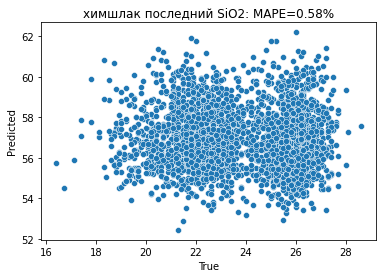

Size of X: (4576, 63)
химшлак последний Al2O3
11.06%
химшлак последний FeO
34.40%
химшлак последний MgO
24.03%
химшлак последний MnO
26.74%
химшлак последний R
5.76%
химшлак последний SiO2
6.73%

Best fitted target: химшлак последний R



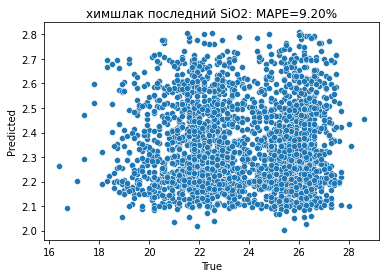

Size of X: (4576, 64)
химшлак последний Al2O3
10.88%
химшлак последний FeO
34.42%
химшлак последний MgO
23.83%
химшлак последний MnO
26.18%
химшлак последний SiO2
5.38%

Best fitted target: химшлак последний SiO2



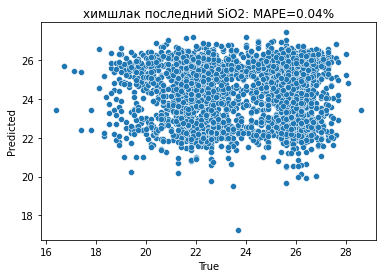

Size of X: (4576, 65)
химшлак последний Al2O3
10.56%
химшлак последний FeO
34.37%
химшлак последний MgO
23.66%
химшлак последний MnO
25.94%

Best fitted target: химшлак последний Al2O3



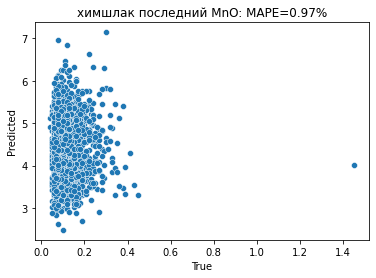

Size of X: (4576, 66)
химшлак последний FeO
34.32%
химшлак последний MgO
23.75%
химшлак последний MnO
26.10%

Best fitted target: химшлак последний MgO



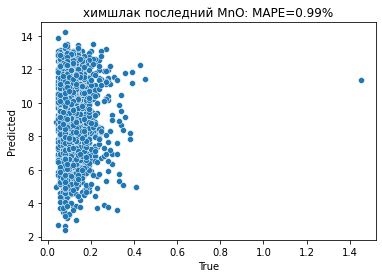

Size of X: (4576, 67)
химшлак последний FeO
34.44%
химшлак последний MnO
26.09%

Best fitted target: химшлак последний MnO



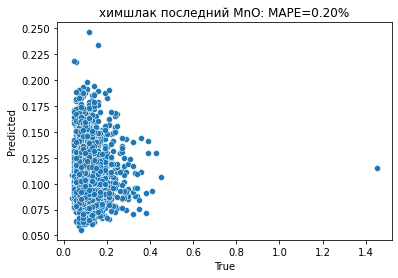

Size of X: (4576, 68)
химшлак последний FeO
33.20%

Best fitted target: химшлак последний FeO



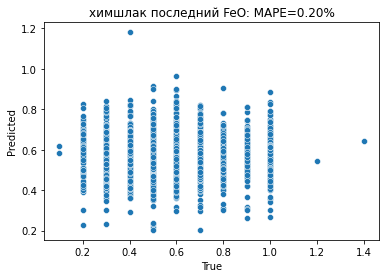

In [88]:
model = CatBoostRegressor(loss_function='MAPE', n_estimators=1000, silent=True)
test_iterative_model_with_plot(model, df, X, target.copy())

## Выводы
* Марка стали была преобразована в бинарный вид с помощью one-hot encoding
* Очищенные данные были нормализованы с помощью StandardScaler
* Все модели тестировались на кросс-валидации с 5-кратным разбиением
*  Линейные модели дают быстрый результат по одновременному предсказанию целевых переменных с средней ошибкой 17%
* Random Forest на тех же данных даёт похожую ошибку но тренируются в несколько раз дольше
* Бустинг (catboos) даёт лучший результат за время сравнимое  со случайным лесом
* Итеративное вычисление признаков с добавлением их в модель даёт наилучший результат на всех моделях
* Catboost с 1000 решателей даёт наилучший результат:
    * химшлак последний CaO 3.74% 
    * химшлак последний R 4.06%
    * химшлак последний SiO2 4.16%
    * химшлак последний Al2O3 7.74%
    * химшлак последний MgO 17.81%
    * химшлак последний MnO 20.34%
    * химшлак последний FeO 20.22%
* Средняя ошибка модели: 11.15%